In [1]:
import pandas as pd
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import string
import pickle
import random
import joblib
import itertools
import warnings
warnings.filterwarnings("ignore")
import scipy as sp
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import sys
sys.path.append("src")
import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
# %env TOKENIZERS_PARALLELISM=true
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import argparse
from utils import *

def get_result(oof_df,is_cla=False):
    labels = oof_df[CFG.target_cols].values
    preds = oof_df[[f"pred_{c}" for c in CFG.target_cols]].values
    if is_cla:
        score, scores = get_score_cla(labels, preds)
    else:
        score, scores = get_score(labels, preds)
    LOGGER.info(f'Score: {score:<.4f}  Scores: {scores}')

class CFG:
    wandb=False
    competition='Hate'
    debug=False
    apex=True
    print_freq=100
    num_workers=6
    model="microsoft/deberta-v3-base"#"Narrativaai/deberta-v3-small-finetuned-hate_speech18"#"microsoft/deberta-v3-base"
    gradient_checkpointing=True
    scheduler='cosine'
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=5
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=12
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    target_cols=['label_mean']#,'HD', 'CV', 'VO','REL', 'RAE', 'SXO', 'GEN', 'IDL', 'NAT', 'POL', 'MPH', 'EX', 'IM']
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    train=True
    pretrain_hate = False
    back_translation = False

tokenizers.__version__: 0.12.1
transformers.__version__: 4.21.2


In [2]:
train = pd.read_csv('./parler-hate-speech/parler_annotated_data_bt.csv')
train[CFG.target_cols] = train[CFG.target_cols] - train[CFG.target_cols].min()
train[CFG.target_cols] = train[CFG.target_cols] / train[CFG.target_cols].max()
Fold = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train[CFG.target_cols+['id']])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)

In [3]:
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
CFG.tokenizer = tokenizer

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
lengths = []
tk0 = tqdm(train['text'].fillna("").values, total=len(train))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
CFG.max_len = min(509,max(lengths)) + 3 # cls & sep & sep

  0%|          | 0/10121 [00:00<?, ?it/s]

In [5]:
model = CustomModel(CFG, config_path=None, pretrained=True,LOGGER = get_logger(filename="temp"))

DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_dropout": 0.0,
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu",
  "hidden_dropout": 0.0,
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share_att_key": true,
  "transformers_version": "4.21.2",
  "type_vocab_size": 0,
  "vocab_size": 128100
}

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model:

In [6]:
class TestDataset(Dataset):
    def __init__(self, cfg, df,text_col = "text"):
        self.cfg = cfg
        df = df.fillna("-9999")
        self.df = df
        self.texts = df[text_col].values
        
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        texts = self.texts[item]
        inputs = prepare_input(self.cfg, texts)
        return inputs

In [7]:
test_dataset_en = TestDataset(CFG,train,text_col = "text")
test_loader_en = DataLoader(test_dataset_en,
                        batch_size=CFG.batch_size * 2,
                        shuffle=False,
                        num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

test_dataset_de = TestDataset(CFG,train,text_col = "BackTranslation_de")
test_loader_de = DataLoader(test_dataset_de,
                        batch_size=CFG.batch_size * 2,
                        shuffle=False,
                        num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

test_dataset_fr = TestDataset(CFG,train,text_col = "BackTranslation_fr")
test_loader_fr = DataLoader(test_dataset_fr,
                        batch_size=CFG.batch_size * 2,
                        shuffle=False,
                        num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

test_dataset_es = TestDataset(CFG,train,text_col = "BackTranslation_es")
test_loader_es = DataLoader(test_dataset_es,
                        batch_size=CFG.batch_size * 2,
                        shuffle=False,
                        num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
test_dataset_no = TestDataset(CFG,train,text_col = "BackTranslation_no")
test_loader_no = DataLoader(test_dataset_no,
                        batch_size=CFG.batch_size * 2,
                        shuffle=False,
                        num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

In [47]:
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,recall_score,roc_auc_score,accuracy_score
import glob
TH_FROM_BASE = 0.7
W = 0.7
MODEL = 'Narrativaai.deberta-v3-small-finetuned-hate_speech18'
EXP = 'outputs_toxigen_backtranslate_reg'
CFG.model = 'Narrativaai/deberta-v3-small-finetuned-hate_speech18'
model = CustomModel(CFG, config_path=None, pretrained=True,LOGGER = get_logger(filename="temp"))
Results_Emb = []
Results_Score = []
for fold in tqdm([0,1,2,3]):
    state = torch.load(glob.glob(f"./{EXP}/{MODEL}/*{fold}_best.pth")[0])
    model.load_state_dict(state["model"])
    model.eval()
    model = model.to(device)
    results_score = []
    results_emb = []
    for loader in tqdm([test_loader_en,test_loader_de,test_loader_fr,test_loader_es,test_loader_no]):
        lg_embeddings = []
        lg_score = []
        for step, (inputs) in enumerate(loader):
            inputs = collate(inputs)
            for k, v in inputs.items():
                inputs[k] = v.to(device)
            with torch.no_grad():
                sentence_embeddings = model.feature(inputs)
                lg_embeddings.append(sentence_embeddings.to('cpu').numpy())
                y_preds = model(inputs)
                lg_score.append(y_preds.to('cpu').numpy())
        lg_score = np.concatenate(lg_score)
        lg_embeddings = np.concatenate(lg_embeddings)
        results_score.append(lg_score)
        results_emb.append(lg_embeddings)
    Results_Emb.append(results_emb)
    Results_Score.append(results_score)
    results = []
    for i in range(len(results_score[0])):
        base = results_score[0][i]
        l = []
        for row in range(1,4):
            if abs(results_score[row][i] - base) < TH_FROM_BASE:
                l.append(results_score[row][i])
        if len(l) ==0:
            results.append(base)
        else:
            results.append(W*base+(1-W)*np.mean(l))
    train[f'tta_score_fold_{fold}'] = results
    val = train[train['fold']==fold]
    res = np.sqrt(mean_squared_error(val['label_mean'],val[f'tta_score_fold_{fold}']))*4    
    print(f"fold - {fold} tta results - {res}")

DebertaV2Config {
  "_name_or_path": "Narrativaai/deberta-v3-small-finetuned-hate_speech18",
  "architectures": [
    "DebertaV2ForSequenceClassification"
  ],
  "attention_dropout": 0.0,
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu",
  "hidden_dropout": 0.0,
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "NO_HATE",
    "1": "HATE",
    "2": "IDK",
    "3": "RELATION"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "HATE": 1,
    "IDK": 2,
    "NO_HATE": 0,
    "RELATION": 3
  },
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "posit

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

fold - 0 tta results - 0.7975324077579827


  0%|          | 0/5 [00:00<?, ?it/s]

fold - 1 tta results - 0.8033848367271456


  0%|          | 0/5 [00:00<?, ?it/s]

fold - 2 tta results - 0.8202415698095473


  0%|          | 0/5 [00:00<?, ?it/s]

fold - 3 tta results - 0.8391460640422563


In [48]:
# W = 0.7
# TH_FROM_BASE = 0.7

# best = 1
# best_w = None
# if True:
#     # TH_FROM_BASE = WW/100.0
#     results = []
#     for i in range(len(results_score[0])):
#         base = results_score[0][i]
#         l = []
#         for row in range(1,4):
#             if abs(results_score[row][i] - base) < TH_FROM_BASE:
#                 l.append(results_score[row][i])
#         if len(l) ==0:
#             results.append(base)
#         else:
#             results.append(W*base+(1-W)*np.mean(l))
#     train[f'tta_score_fold_{fold}'] = results
#     val = train[train['fold']==fold]
#     res = np.sqrt(mean_squared_error(val['label_mean'],val[f'tta_score_fold_{fold}']))*4  
#     # if res < best:
#     #     best=res
#     #     best_w = TH_FROM_BASE
#         # print(f"{best_w},{res}")
# # print(best_w)
# print(f"fold - {fold} tta results - {res}")

In [49]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
pca = PCA(n_components=2)
val = train[train['fold']==fold]
val_lsit = list(val.index)
X = np.array(Results_Emb[0]).transpose(1,0,2)[val_lsit].transpose(1,0,2)
XX = []
YY = []
for i,row in enumerate(X):
    XX.append(row)
    YY.append(np.ones_like(row)*i)
XX = np.concatenate(XX)
YY = np.concatenate(YY)[:,0]
X_r = pca.fit(XX).transform(XX)
lda = LinearDiscriminantAnalysis(n_components=2,store_covariance=True)
X_r2 = lda.fit(XX, YY).transform(XX)

label mean: 2.25
label mean: 4.6666665
label mean: 1.0
label mean: 1.25


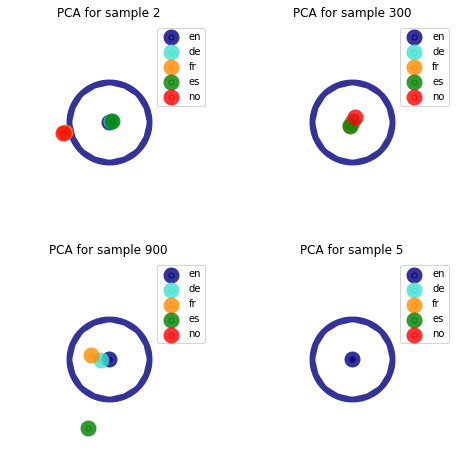

In [117]:
from matplotlib import pyplot as plt
# results_score = Results_Score[0]
plt.figure(figsize=[8,8])
# r+=1
for z,F in enumerate([r,300,900,5]):
    row = val.iloc[F]
    gt = row['label_mean']*4+1
    print("label mean:",gt)
    # print("en: ", row['text'],"score: ",results_score[0,F,0]*4+1)
    # print("de: ", row['BackTranslation_de'],"score: ",results_score[1,F,0]*4+1)
    # print("fr: ", row['BackTranslation_fr'],"score: ",results_score[2,F,0]*4+1)
    # print("es: ", row['BackTranslation_es'],"score: ",results_score[3,F,0]*4+1)
    # print("no: ", row['BackTranslation_no'],"score: ",results_score[4,F,0]*4+1)
    # print("en: ", row['text'])
    # print("de: ", row['BackTranslation_de'])
    # print("fr: ", row['BackTranslation_fr'])
    # print("es: ", row['BackTranslation_es'])
    # print("no: ", row['BackTranslation_no'])
    plt.subplot(2,2,z+1)
    X0 = np.array([X_r[len(val_lsit)*0+F],X_r[len(val_lsit)*1+F],X_r[len(val_lsit)*2+F],X_r[len(val_lsit)*3+F],X_r[len(val_lsit)*4+F]])
    target_names = ['en','de','fr','es','no']    
    colors = ["navy", "turquoise", "darkorange",'green',"red"]
    lw = 4

    for color, i, target_name in zip(colors, [0, 1, 2,3,4], target_names):
        if i==0:
            plt.scatter(
                X0[i,0], X0[i,1], color=color, alpha=0.8, lw=80, label=None
            )
        plt.scatter(
            X0[i,0], X0[i,1], color=color, alpha=0.8, lw=10, label=target_name
        )
    
    center = (X0[0,0],X0[0,1])
    plt.title(f"PCA for sample {F}")
    plt.xlim(-4+center[0],4+center[0])
    plt.ylim(-4+center[1],4+center[1])
    plt.axis('off')
    plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.show()

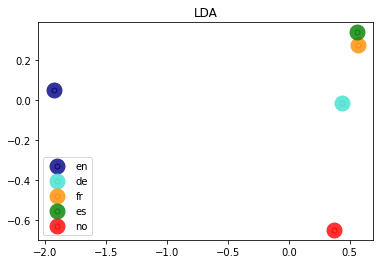

In [70]:
plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2,3,4], target_names):
    plt.scatter(
        X_r2[YY == i, 0].mean(), X_r2[YY == i, 1].mean(), alpha=0.8, color=color, label=target_name, lw=10
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA")

plt.show()

Text(0.5, 1.0, 'TSNE')

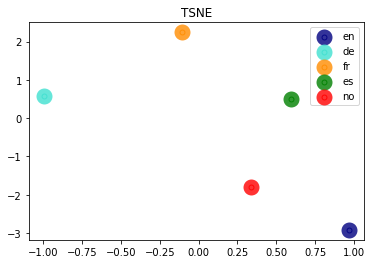

In [71]:
from sklearn.manifold import TSNE
X_r = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3,random_state=42).fit_transform(XX)
for color, i, target_name in zip(colors, [0, 1, 2,3,4], target_names):
    plt.scatter(
        X_r[YY == i, 0].mean(), X_r[YY == i, 1].mean(), color=color, alpha=0.8, lw=10, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("TSNE")

In [51]:
tta_res = []
label = []
for fold in [0,1,2,3]:
    val = train[train['fold']==fold]
    s = list(np.array(val[f'tta_score_fold_{fold}']).reshape(-1))
    l = list(np.array(val[f'label_mean']).reshape(-1))
    tta_res = tta_res + s
    label = label + l

In [52]:
def fix(row):
    return row[0]
train['tta_score_fold_0'] = train['tta_score_fold_0'].apply(fix)
train['tta_score_fold_1'] = train['tta_score_fold_1'].apply(fix)
train['tta_score_fold_2'] = train['tta_score_fold_2'].apply(fix)
train['tta_score_fold_3'] = train['tta_score_fold_3'].apply(fix)
# train.to_pickle(f"./{EXP}/{MODEL}/tta.pkl")

In [53]:
without_tta = pd.read_pickle(f"./{EXP}/{MODEL}/oof_df.pkl")
without_tta_score = np.sqrt(mean_squared_error(without_tta['label_mean'],without_tta['pred_label_mean']))*4  
with_tta_score = np.sqrt(mean_squared_error(label,tta_res))*4 
print(f"TTA improve model {MODEL} RMSE score from {without_tta_score} to {with_tta_score} (diff: {without_tta_score - with_tta_score})")

TTA improve model Narrativaai.deberta-v3-small-finetuned-hate_speech18 RMSE score from 0.8222354569760574 to 0.8152378060348867 (diff: 0.006997650941170663)


In [44]:
train2 = [pd.read_pickle(row).sort_values("id").reset_index(drop=True) for row in glob.glob(f"./{EXP}/*/*tta*")]
print(len(train2))
tta_res = []
label = []
for fold in [0,1,2,3]:
    val0 = train2[0][train2[0]['fold']==fold]
    val1 = train2[1][train2[1]['fold']==fold]
    val2 = train2[2][train2[2]['fold']==fold]
    s = list(np.array(val0[f'tta_score_fold_{fold}']).reshape(-1) + np.array(val1[f'tta_score_fold_{fold}']).reshape(-1) + np.array(val2[f'tta_score_fold_{fold}']).reshape(-1))
    s = np.array(s)/len(train2)
    l = list(np.array(val0[f'label_mean']).reshape(-1))
    tta_res = tta_res + list(s)
    label = label + l
ensemble_tta = np.sqrt(mean_squared_error(label,np.array(tta_res)))*4    
pkl = [pd.read_pickle(row).sort_values("id").reset_index(drop=True) for row in glob.glob(f"{EXP}/*/*.pkl") if "_reg" in row and "tta" not in row and 'unitary' not in row]
pred = [row['pred_label_mean'].values for row in pkl]
target = [row['label_mean'].values for row in pkl]
ensemble_without_tta = np.sqrt(mean_squared_error(np.mean(target,axis=0),np.mean(pred,axis=0)))*4 
print(f"TTA improve ensemble {EXP} RMSE score from {ensemble_without_tta} to {ensemble_tta} (diff: {ensemble_without_tta - ensemble_tta})")

3
TTA improve ensemble outputs_toxigen_backtranslate_reg RMSE score from 0.7769798226061512 to 0.7757076691500598 (diff: 0.0012721534560913295)


In [45]:
len(train2)

3